# Visualization of COVID-19 statistics

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from SPARQLWrapper import SPARQLWrapper, JSON, POST
import json

In [6]:
# Initializations
prefixes = '''
prefix covidpr:<http://ns.inria.fr/covid19/property/>
prefix owl:    <http://www.w3.org/2002/07/owl#>
prefix rdf:    <http://www.w3.org/1999/02/22-rdf-syntax-ns#>
prefix rdfs:   <http://www.w3.org/2000/01/rdf-schema#>
prefix schema: <http://schema.org/>
prefix wdt:    <http://www.wikidata.org/prop/direct/>
prefix wd:     <http://www.wikidata.org/entity/>
prefix xsd:    <http://www.w3.org/2001/XMLSchema#>
'''

In [7]:
endpoint = 'https://covidontheweb.inria.fr/sparql'

In [8]:
def exec_sparql(endpoint, query):
    """
    Execute a SPARQL query and return results as a Pandas DataFrame.
    Invocation uses the HTTP POST method. Requested result format is JSON.

    In case of failure, the function retries up to MAX_ATTEMPTS attempts while waiting increasing time between each attempt.
    An empty DataFrame is returned in case no attempt is successful.
    """
    # Max number of time a SPARQL query can fail before giving up
    MAX_ATTEMPTS = 3

    sparql = SPARQLWrapper(endpoint)
    sparql.setMethod(POST)
    sparql.setReturnFormat(JSON)
    sparql.setQuery(query)
    
    attempt = 1;
    success = False
    while not success and attempt <= MAX_ATTEMPTS:
        try:
            raw_results = sparql.query()
            results = raw_results.convert()
        except:
            print(f'Error while executing SPARQL query (attempt {attempt}/{MAX_ATTEMPTS}).', end=' ')
            if attempt < MAX_ATTEMPTS:
                # Wait a few seconds before next attempt (5, 10, 15, ...)
                print(f'Will retry in {attempt * 5}s.')
                sleep(attempt * 5)
        else:
            success = True
        finally:
            attempt = attempt + 1

    if success:
        if 'head' in results and 'results' in results:
            cols = results['head']['vars']
            out = []
            for row in results['results']['bindings']:
                item = []
                for c in cols:
                    item.append(row.get(c, {}).get('value'))
                out.append(item)
            return pd.DataFrame(out, columns=cols)
        else:
            print('Invalid SPARQL result. Will return empty DataFrame.\n' + str(results))
    else:
        print(f'Unable to execute SPARQL query after {MAX_ATTEMPTS} attempts. Will return empty DataFarme.')
                  
    return pd.DataFrame()            


def dataframe_preview(df, start=0, end=10):
    print("== Number of lines: " + str(df.shape[0]))
    print("== Number of unique values:")
    print(df.nunique())
    display(df[start:end])

___
## Display record of cases hospitalized or in intensive care, and deaths

Comment/uncomment the lines in the object of schema:spatialCoverage to visualized the whole country, or per region or department.

In [9]:
query = prefixes + '''
select ?date ?deaths ?hospitalized ?intensive from <http://ns.inria.fr/covid19/graph/datagouvfr>
where {
    ?a  a schema:SpecialAnnouncement;
        schema:datePosted ?date;
        schema:spatialCoverage [
            # on the whole country
            a         wd:Q3624078; # state

            # on one department
            #a            wd:Q6465; # French department
            #wdt:P2586    "06";     # INSEE department code
        ];
        schema:diseaseSpreadStatistics [
            schema:measuredProperty wdt:P1120; # number of deaths
            schema:measuredValue ?deaths
        ];
        schema:diseaseSpreadStatistics [
            schema:measuredProperty wdt:P8049; # number of hospitalized cases
            schema:measuredValue ?hospitalized
        ];
        schema:diseaseSpreadStatistics [
            schema:measuredProperty <http://ns.inria.fr/covid19/property/noCasesIntensiveCare>;
            schema:measuredValue ?intensive
        ].
} order by ?date
'''

In [10]:
%time df = exec_sparql(endpoint, query)

Wall time: 310 ms


In [11]:
# Prepare data
df.deaths = df.deaths.astype(int)
df.hospitalized = df.hospitalized.astype(int)
df.intensive = df.intensive.astype(int)
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)

dataframe_preview(df, end=10)

== Number of lines: 610
== Number of unique values:
deaths          609
hospitalized    594
intensive       563
dtype: int64


,deaths,hospitalized,intensive
date,,,
2020-03-18,218,2972,771
2020-03-19,327,4073,1002
2020-03-20,450,5226,1297
2020-03-21,525,5900,1453
2020-03-22,632,6954,1674
2020-03-23,860,8673,2080
2020-03-24,1100,10163,2503
2020-03-25,1388,12072,2935
2020-03-26,1696,13879,3351


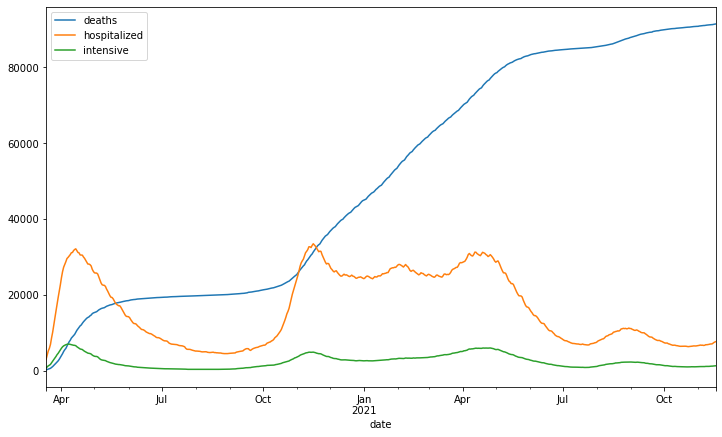

In [12]:
fig, ax = plt.subplots(figsize=(12,7))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
df.plot(ax=ax)
plt.show()

___
## Display propagation of COVID19 virus mutations

Comment/uncomment the lines in the object of schema:spatialCoverage to visualized the whole country, or per region or department.

In [47]:
query = prefixes + '''
select ?date ?propA ?propB ?propC from <http://ns.inria.fr/covid19/graph/datagouvfr>
where {
    ?a  a schema:SpecialAnnouncement;
        schema:datePosted ?date;
        schema:spatialCoverage [
            # on the whole country
            a         wd:Q3624078; # state

            # on one department
            #a            wd:Q6465; # French department
            #wdt:P2586    "06";     # INSEE department code
        ];
        schema:diseaseSpreadStatistics [
            schema:measuredProperty covidpr:propagationVariantA;
            schema:measuredValue ?propA
        ];
        schema:diseaseSpreadStatistics [
            schema:measuredProperty covidpr:propagationVariantB;
            schema:measuredValue ?propB
        ];
        schema:diseaseSpreadStatistics [
            schema:measuredProperty covidpr:propagationVariantC;
            schema:measuredValue ?propC
        ].
} order by ?date
'''

In [48]:
%time df = exec_sparql(endpoint, query)

Wall time: 265 ms


In [50]:
# Prepare data
df.propA = df.propA.astype(float)
df.propB = df.propB.astype(float)
df.propC = df.propC.astype(float)
df.date = pd.to_datetime(df.date, format='%Y-%m-%d')
df.set_index('date', inplace=True)

dataframe_preview(df, end=10)

== Number of lines: 162
== Number of unique values:
propA    62
propB    18
propC    90
dtype: int64


,propA,propB,propC
date,,,
2021-06-06,16.9,0.4,2.2
2021-06-07,17.9,0.4,2.7
2021-06-08,18.9,0.5,3.3
2021-06-09,19.7,0.5,4.1
2021-06-10,20.1,0.6,4.4
2021-06-11,20.5,0.6,4.5
2021-06-12,20.3,0.6,5.0
2021-06-13,20.3,0.7,5.1
2021-06-14,20.1,0.8,6.3


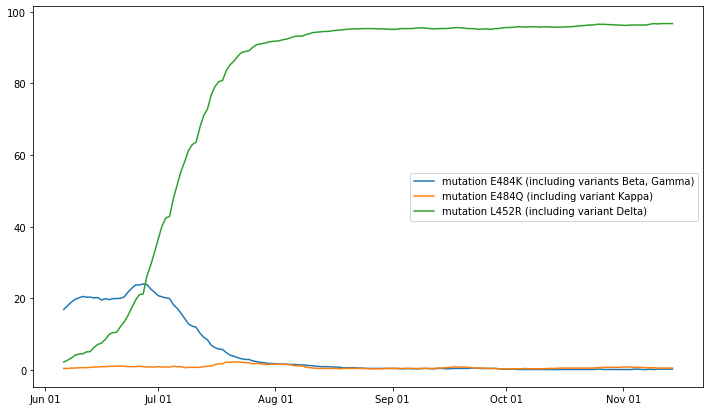

In [51]:
fig, ax = plt.subplots(figsize=(12,7))
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.plot(df['propA'], label='mutation E484K (including variants Beta, Gamma)')
plt.plot(df['propB'], label='mutation E484Q (including variant Kappa)')
plt.plot(df['propC'], label='mutation L452R (including variant Delta)')
plt.legend()
plt.show()